# 3. Modeling and Evaluation

In this section, we build and evaluate five machine learning models — Decision Tree, K-Nearest Neighbors, Random Forest, Gradient Boosting (XGBoost), and Support Vector Machine — to classify mushrooms as either edible or poisonous.
We begin with a Decision Tree as a baseline model, assess its performance using several metrics, and visualize its structure and feature importance.
Our goal is to balance overall accuracy and to identify both the best-performing algorithm and the features that drive its predictions.

## 0. Import and dataset


In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, make_scorer, zero_one_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate, cross_val_predict, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import tree
from xgboost import XGBClassifier
import pandas as pd
import sys
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import fcntl
import warnings
import time



warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message=r".*use_label_encoder.*")

In [16]:
df = pd.read_csv('./Data/processed_train.csv')
df_copy = df.copy()

## 1. Baseline Model

To establish a benchmark for comparison, we start with a Decision Tree Classifier. This model is fast to train, handles categorical variables well, and provides interpretable decision paths and feature importances.


### Splitting and Encoding the Dataset

We encode all categorical variables using `LabelEncoder`, including the target variable (`class`).
The dataset is then split into training and test sets using a stratified split to maintain the class distribution.


In [17]:
X = df.drop('class', axis=1)
y = df['class']

# one hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)
feature_names = X_encoded.columns

# Label encoding for the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

### Training the Model

We train a `DecisionTreeClassifier` on the training set with a fixed `random_state` for reproducibility.


In [18]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Evaluating the Model with Cross-Validation

To obtain a robust estimate of model performance, we use `cross_validate()` with 5-fold cross-validation. This provides fold-wise metrics for accuracy, precision, recall, and F1-score, which are then averaged to summarize overall model behavior.

In addition to aggregated scores, we apply `cross_val_predict()` to generate cross-validated predictions and predicted probabilities for the entire dataset. This allows us to:

- Compute a **confusion matrix** and **classification report** across all folds.
- Visualize the **ROC curve**, providing insights into the model's trade-off between true positive and false positive rates.
- Calculate the **ROC AUC score** to evaluate the model’s ability to distinguish between classes.

This approach ensures that we not only assess average performance but also analyze the consistency and reliability of predictions across the full dataset.


Cross-validation results (5-fold):
Average Accuracy: 0.9777
Average Precision: 0.9799
Average Recall: 0.9792
Average F1: 0.9796

Confusion Matrix (Cross-Validated):
[[44216  1097]
 [ 1135 53552]]

Classification Report (Cross-Validated):
              precision    recall  f1-score   support

      edible       0.97      0.98      0.98     45313
   poisonous       0.98      0.98      0.98     54687

    accuracy                           0.98    100000
   macro avg       0.98      0.98      0.98    100000
weighted avg       0.98      0.98      0.98    100000


ROC AUC Score (Cross-Validated): 0.9775


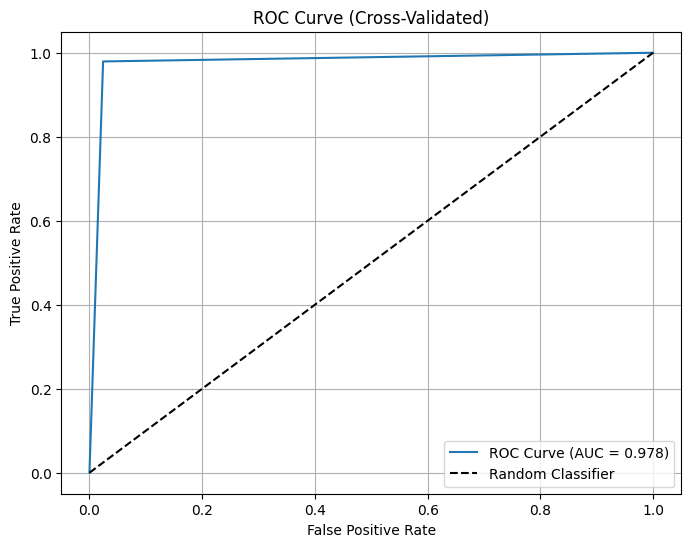

In [19]:
# Cross-validation scores
cv_results = cross_validate(
    clf, X_scaled, y_encoded, cv=5,
    scoring=['accuracy', 'precision', 'recall', 'f1'],
    return_estimator=False
)

# Print averaged metrics
print("Cross-validation results (5-fold):")
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    print(f"Average {metric.capitalize()}: {cv_results[f'test_{metric}'].mean():.4f}")

# Get predictions and predicted probabilities across all folds
y_pred_cv = cross_val_predict(clf, X_scaled, y_encoded, cv=5)
y_prob_cv = cross_val_predict(clf, X_scaled, y_encoded, cv=5, method='predict_proba')[:, 1]

# Confusion Matrix & Classification Report
print("\nConfusion Matrix (Cross-Validated):")
print(confusion_matrix(y_encoded, y_pred_cv))

print("\nClassification Report (Cross-Validated):")
print(classification_report(y_encoded, y_pred_cv, target_names=["edible", "poisonous"]))

# ROC Curve
fpr, tpr, _ = roc_curve(y_encoded, y_prob_cv)
roc_auc = roc_auc_score(y_encoded, y_prob_cv)

print(f"\nROC AUC Score (Cross-Validated): {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Cross-Validated)")
plt.legend()
plt.grid(True)
plt.show()

### Tree Visualization

We visualize the full structure of the trained decision tree to understand its decision rules.
Due to the depth and number of features, the tree is large and may be pruned or simplified later for interpretability.


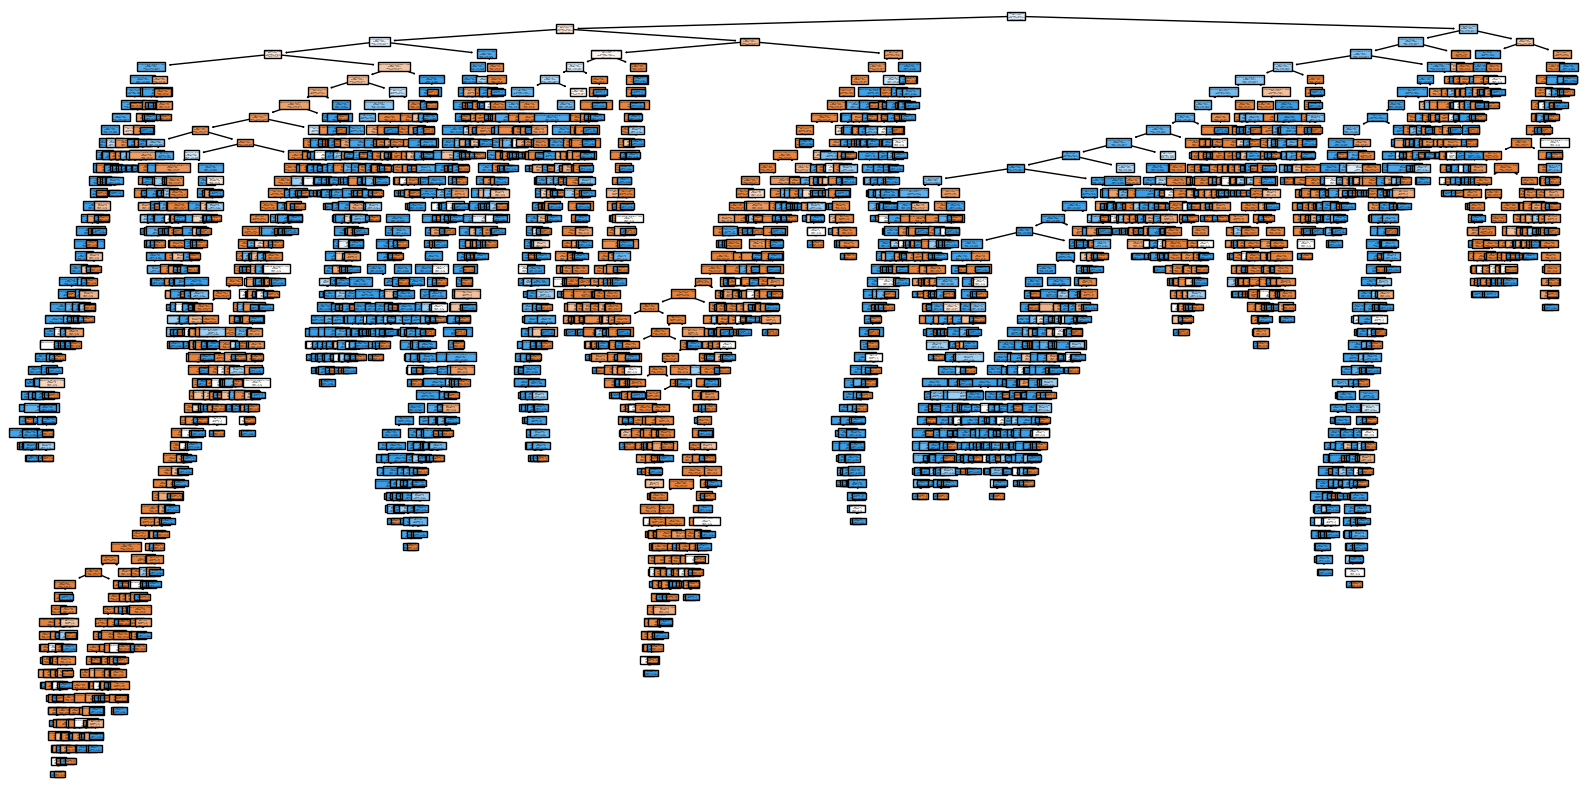

In [17]:
plt.figure(figsize=(20, 10))
tree.plot_tree(
    clf,
    filled=True,
    feature_names=feature_names,
    class_names=["edible", "poisonous"]
)
plt.show()


The tree is very deep and heavily branched, suggesting a risk of overfitting. Many features are involved, and some branches reach deep levels, likely to correctly classify rare or ambiguous cases.

To improve generalization and model transparency, the tree could benefit from pruning or limiting its depth. This would maintain performance while producing a model that is easier to interpret and communicate.


### Feature Importance

The top 10 most important features used by the decision tree are displayed in a horizontal bar chart.
This analysis provides insights into which mushroom characteristics are most predictive of toxicity.


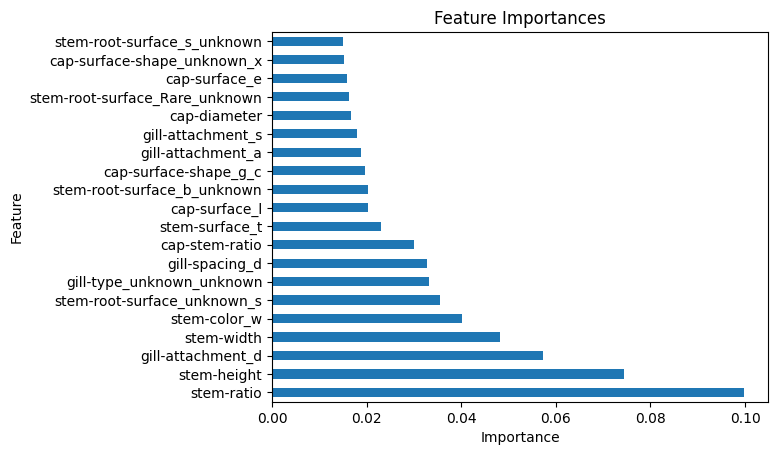

In [ ]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


The feature importance plot reveals that a small number of physical mushroom characteristics dominate the Decision Tree's decisions. Notably, `stem-ratio`, `stem-height`, and `gill-attachment_d` are among the most influential features.

These findings suggest that structural properties such as stem dimensions and gill configuration are strong indicators of mushroom toxicity. Interestingly, even "unknown" or rare values carry predictive power, implying that less common observations should not be dismissed during preprocessing.

The sharp decline in importance after the top features also indicates that the model's complexity might be reduced without a significant loss in performance, which can inform future feature selection or model simplification efforts.


## 2. Combined Feature Selection: Variance Threshold + RFECV

To build a more compact and informative feature set, we first apply a **Variance Threshold** to remove features with little or no variability. These low-variance features are unlikely to contribute meaningfully to model performance, especially in one-hot encoded datasets where many features can be sparse.

Next, we apply **Recursive Feature Elimination with Cross-Validation (RFECV)** using a **Logistic Regression** estimator. Logistic Regression is chosen for its speed and interpretability, making it ideal for iterative feature elimination. RFECV evaluates feature subsets across cross-validation folds and automatically selects the number of features that yields the best average performance.

This two-step approach allows us to reduce dimensionality in a way that is both statistically informed and computationally efficient. It avoids the rigidity of Forward and Backward Selection, which require a fixed number of features to be manually defined and often lack scalability.

Once the most relevant features have been selected, we may apply **PCA** as a final step, not to discover the best components, but to **further reduce dimensionality** in a way that’s agnostic to model structure. This is particularly useful to compress the dataset for faster training of more complex models.

By chaining feature selection and PCA, we can retain the most meaningful information while optimizing for both **accuracy** and **efficiency** in downstream modeling.

**Notes:**
In future modeling we observed that while this reduced feature space substantially and helped linear models like Logistic Regression, it led to a drop in performance for tree-based models. This aligns with the fact that tree-based models are generally robust to irrelevant features and benefit from richer input feature spaces for complex splitting.


In [19]:
# Variance threshold
var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X_encoded)

print(f"Features removed with variance threshold: {X_encoded.shape[1] - X_var.shape[1]}")

# Scale the filtered data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_var)

# RFECV with Logistic Regression
log_reg = LogisticRegression(penalty='l2', solver='liblinear', max_iter=500, random_state=42)
cv = StratifiedKFold(n_splits=5)

rfecv = RFECV(
    estimator=log_reg,
    step=5,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

X_reduced = rfecv.fit_transform(X_scaled, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Features removed with variance threshold: 119
Fitting estimator with 200 features.
Fitting estimator with 200 features.
Fitting estimator with 200 features.
Fitting estimator with 200 features.
Fitting estimator with 200 features.
Fitting estimator with 195 features.
Fitting estimator with 195 features.
Fitting estimator with 195 features.
Fitting estimator with 195 features.
Fitting estimator with 195 features.
Fitting estimator with 190 features.
Fitting estimator with 190 features.
Fitting estimator with 190 features.
Fitting estimator with 190 features.
Fitting estimator with 190 features.
Fitting estimator with 185 features.
Fitting estimator with 185 features.
Fitting estimator with 185 features.
Fitting estimator with 185 features.
Fitting estimator with 185 features.
Fitting estimator with 180 features.
Fitting estimator with 180 features.
Fitting estimator with 180 features.
Fitting estimator with 180 features.
Fitting estimator with 180 features.
Fitting estimator with 175 fe

In [20]:
var_mask = var_thresh.get_support()
X_var_names = X_encoded.columns[var_mask]

rfecv_mask = rfecv.support_
X_selected_names = X_var_names[rfecv_mask]

print("Selected features after VarianceThreshold + RFECV:")
print(X_selected_names.tolist())

Selected features after VarianceThreshold + RFECV:
['cap-diameter', 'stem-height', 'stem-width', 'stem-area', 'stem-volume', 'stem-ratio', 'cap-shape_b', 'cap-shape_c', 'cap-shape_f', 'cap-shape_p', 'cap-shape_x', 'cap-surface_d', 'cap-surface_g', 'cap-surface_h', 'cap-surface_i', 'cap-surface_k', 'cap-surface_l', 'cap-surface_s', 'cap-surface_t', 'cap-surface_unknown', 'cap-surface_w', 'cap-surface_y', 'cap-color_b', 'cap-color_e', 'cap-color_g', 'cap-color_k', 'cap-color_l', 'cap-color_n', 'cap-color_o', 'cap-color_r', 'cap-color_w', 'does-bruise-or-bleed_f', 'does-bruise-or-bleed_t', 'gill-attachment_a', 'gill-attachment_d', 'gill-attachment_e', 'gill-attachment_f', 'gill-attachment_p', 'gill-attachment_s', 'gill-attachment_unknown', 'gill-attachment_x', 'gill-spacing_c', 'gill-spacing_f', 'gill-spacing_unknown', 'gill-color_b', 'gill-color_f', 'gill-color_g', 'gill-color_n', 'gill-color_o', 'gill-color_p', 'gill-color_u', 'gill-color_w', 'gill-color_y', 'stem-root_b', 'stem-root_r'

Number of selected features: 175


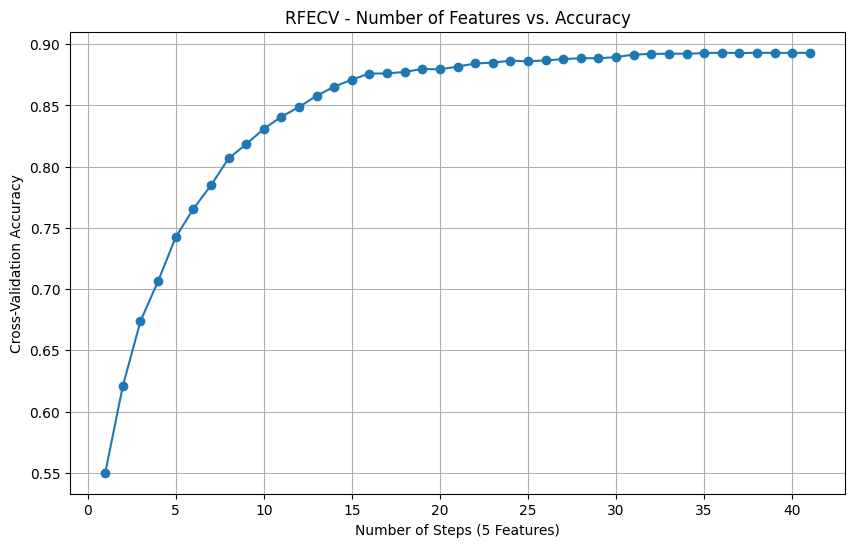

In [21]:
print(f"Number of selected features: {rfecv.n_features_}")


plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    rfecv.cv_results_["mean_test_score"],
    marker='o'
)
plt.xlabel("Number of Steps (5 Features)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("RFECV - Number of Features vs. Accuracy")
plt.grid(True)
plt.show()


In [22]:
X_train_threshold = var_thresh.transform(X_train)
X_test_threshold = var_thresh.transform(X_test)

X_train_reduced, X_test_reduced = rfecv.transform(X_train_threshold), rfecv.transform(X_test_threshold)

In [23]:
reduced_feature_list = ['cap-diameter', 'stem-height', 'stem-width', 'stem-area', 'stem-volume', 'stem-ratio', 'cap-shape_b', 'cap-shape_c', 'cap-shape_f', 'cap-shape_p', 'cap-shape_x', 'cap-surface_d', 'cap-surface_g', 'cap-surface_h', 'cap-surface_i', 'cap-surface_k', 'cap-surface_l', 'cap-surface_s', 'cap-surface_t', 'cap-surface_unknown', 'cap-surface_w', 'cap-surface_y', 'cap-color_b', 'cap-color_e', 'cap-color_g', 'cap-color_k', 'cap-color_l', 'cap-color_n', 'cap-color_o', 'cap-color_r', 'cap-color_w', 'does-bruise-or-bleed_f', 'does-bruise-or-bleed_t', 'gill-attachment_a', 'gill-attachment_d', 'gill-attachment_e', 'gill-attachment_f', 'gill-attachment_p', 'gill-attachment_s', 'gill-attachment_unknown', 'gill-attachment_x', 'gill-spacing_c', 'gill-spacing_f', 'gill-spacing_unknown', 'gill-color_b', 'gill-color_f', 'gill-color_g', 'gill-color_n', 'gill-color_o', 'gill-color_p', 'gill-color_u', 'gill-color_w', 'gill-color_y', 'stem-root_b', 'stem-root_r', 'stem-root_s', 'stem-root_unknown', 'stem-surface_g', 'stem-surface_i', 'stem-surface_k', 'stem-surface_s', 'stem-surface_t', 'stem-surface_unknown', 'stem-surface_y', 'stem-color_e', 'stem-color_g', 'stem-color_k', 'stem-color_n', 'stem-color_o', 'stem-color_p', 'stem-color_u', 'stem-color_w', 'stem-color_y', 'veil-type_u', 'veil-type_unknown', 'veil-color_unknown', 'veil-color_w', 'has-ring_f', 'has-ring_t', 'ring-type_e', 'ring-type_f', 'ring-type_g', 'ring-type_l', 'ring-type_p', 'ring-type_r', 'ring-type_unknown', 'ring-type_z', 'spore-print-color_k', 'spore-print-color_p', 'spore-print-color_unknown', 'spore-print-color_w', 'habitat_d', 'habitat_g', 'habitat_h', 'habitat_l', 'habitat_m', 'season_s', 'season_u', 'season_w', 'gill-type_a_c', 'gill-type_a_d', 'gill-type_a_unknown', 'gill-type_d_c', 'gill-type_d_unknown', 'gill-type_e_unknown', 'gill-type_p_unknown', 'gill-type_s_c', 'gill-type_s_d', 'gill-type_s_unknown', 'gill-type_unknown_c', 'gill-type_unknown_d', 'gill-type_x_c', 'gill-type_x_d', 'ring-profile_f_f', 'ring-profile_t_e', 'ring-profile_t_f', 'ring-profile_t_g', 'ring-profile_t_l', 'ring-profile_t_p', 'ring-profile_t_r', 'ring-profile_t_unknown', 'ring-profile_t_z', 'habitat-season_d_a', 'habitat-season_d_u', 'habitat-season_d_w', 'habitat-season_g_a', 'habitat-season_g_u', 'habitat-season_h_a', 'habitat-season_h_u', 'habitat-season_l_a', 'habitat-season_l_u', 'habitat-season_m_a', 'habitat-season_m_u', 'cap-surface-shape_d_f', 'cap-surface-shape_d_s', 'cap-surface-shape_d_x', 'cap-surface-shape_e_x', 'cap-surface-shape_g_b', 'cap-surface-shape_g_x', 'cap-surface-shape_h_b', 'cap-surface-shape_h_f', 'cap-surface-shape_h_x', 'cap-surface-shape_i_x', 'cap-surface-shape_k_x', 'cap-surface-shape_s_f', 'cap-surface-shape_t_b', 'cap-surface-shape_unknown_b', 'cap-surface-shape_unknown_f', 'cap-surface-shape_unknown_s', 'cap-surface-shape_unknown_x', 'cap-surface-shape_y_b', 'cap-surface-shape_y_x', 'stem-root-surface_b_unknown', 'stem-root-surface_s_unknown', 'stem-root-surface_unknown_g', 'stem-root-surface_unknown_k', 'stem-root-surface_unknown_s', 'stem-root-surface_unknown_t', 'stem-root-surface_unknown_unknown', 'stem-root-surface_unknown_y', 'has-root_yes', 'season-type_warm', 'cap-diameter-bin_medium', 'cap-diameter-bin_small', 'stem-height-bin_short', 'stem-height-bin_tall', 'stem-width-bin_narrow', 'stem-width-bin_wide', 'stem-volume-bin_medium', 'stem-volume-bin_small', 'stem-area-bin_small', 'stem-ratio-bin_low', 'stem-ratio-bin_medium', 'cap-stem-ratio-bin_low', 'cap-stem-ratio-bin_medium']

X_train_full_df = pd.DataFrame(X_train, columns=X_encoded.columns)
X_test_full_df = pd.DataFrame(X_test, columns=X_encoded.columns)

X_train_reduced = X_train_full_df[reduced_feature_list]
X_test_reduced = X_test_full_df[reduced_feature_list]


The RFECV process selected **175** features as the optimal subset, balancing accuracy and model simplicity. This selection was performed after applying a Variance Threshold filter, which had already removed **119 low-variance features** from the original 319. The resulting reduced set will be used for future modeling and optional dimensionality reduction with PCA.


## 3. Principal Component Analysis (PCA)

In this section, we evaluate the effect of applying PCA as a dimensionality reduction technique on the performance of a K-Nearest Neighbors (KNN) classifier.

KNN is a distance-based algorithm that is particularly sensitive to the number and scale of input features. As the number of features increases, KNN can suffer from the "curse of dimensionality", which leads to reduced classification accuracy. Applying PCA can help by projecting the data into a lower-dimensional space that retains most of the original variance while removing noise and redundancy.

We first evaluate the performance of KNN without PCA as a baseline. Then, we apply PCA with varying numbers of components and observe the impact on classification accuracy. This analysis helps us determine whether reducing dimensionality improves performance and which number of components offers the best trade-off between dimensionality and predictive power.

The results are visualized to show how accuracy changes as a function of the number of principal components retained.


In [24]:
def test_pca(X_train_fs, X_test_fs, y_train, y_test, start_components, end_components, step):
    # Testing non PCA model
    model = KNeighborsClassifier()
    start = time.time()
    model.fit(X_train_fs, y_train)
    y_pred = model.predict(X_test_fs)
    end = time.time()

    score = accuracy_score(y_test, y_pred)
    default_time = end - start

    print(f"Default model, Accuracy: {score:.4f}, Execution Time: {default_time:.4f} seconds")

    # Apply PCA
    pca = PCA(random_state=42)
    X_train_pca_full = pca.fit_transform(X_train_fs)
    X_test_pca_full = pca.transform(X_test_fs)

    scores = []
    times = []
    components = range(start_components, end_components + 1, step)

    for i in components:
        X_train_pca = X_train_pca_full[:, :i]
        X_test_pca = X_test_pca_full[:, :i]

        model = KNeighborsClassifier()
        start = time.time()
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        end = time.time()
        
        score = accuracy_score(y_test, y_pred)
        exec_time = end - start

        scores.append(score)
        times.append(exec_time)

        print(f"Components: {i}, Accuracy: {score:.4f}, Time: {exec_time:.4f} seconds")
        
    # Highest accuracy and corresponding components
    max_accuracy = max(scores)
    max_index = scores.index(max_accuracy)
    best_components = components[max_index]
    print(f"Best number of components: {best_components} with accuracy: {max_accuracy:.4f}")


    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(components, scores, marker='o', label='PCA Accuracy')
    plt.axhline(y=score, color='red', linestyle='--', label=f'Baseline Accuracy ({score:.2f})')

    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy')
    plt.title('PCA vs. Baseline Accuracy (KNN)')
    plt.xticks(components)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot execution time
    plt.figure(figsize=(10, 6))
    plt.plot(components, times, marker='o', color='orange', label='PCA Execution Time')
    plt.axhline(y=default_time, color='red', linestyle='--', label=f'Baseline Time ({default_time:.4f}s)')

    plt.xlabel('Number of Components')
    plt.ylabel('Execution Time (s)')
    plt.title('PCA vs. Baseline Execution Time (KNN)')
    plt.xticks(components)
    plt.grid(True)
    plt.legend()
    plt.show()


Default model, Accuracy: 0.9897, Execution Time: 5.1858 seconds
Components: 1, Accuracy: 0.5656, Time: 0.8817 seconds
Components: 8, Accuracy: 0.9832, Time: 1.5351 seconds
Components: 15, Accuracy: 0.9880, Time: 1.8426 seconds
Components: 22, Accuracy: 0.9890, Time: 2.3631 seconds
Components: 29, Accuracy: 0.9895, Time: 2.5642 seconds
Components: 36, Accuracy: 0.9895, Time: 2.9277 seconds
Components: 43, Accuracy: 0.9894, Time: 3.5521 seconds
Components: 50, Accuracy: 0.9894, Time: 3.6317 seconds
Components: 57, Accuracy: 0.9890, Time: 3.6667 seconds
Components: 64, Accuracy: 0.9894, Time: 3.9529 seconds
Components: 71, Accuracy: 0.9890, Time: 3.9026 seconds
Components: 78, Accuracy: 0.9890, Time: 3.9245 seconds
Components: 85, Accuracy: 0.9890, Time: 4.0666 seconds
Components: 92, Accuracy: 0.9891, Time: 4.2977 seconds
Components: 99, Accuracy: 0.9893, Time: 4.5710 seconds
Components: 106, Accuracy: 0.9893, Time: 4.7372 seconds
Components: 113, Accuracy: 0.9895, Time: 5.0076 seconds
C

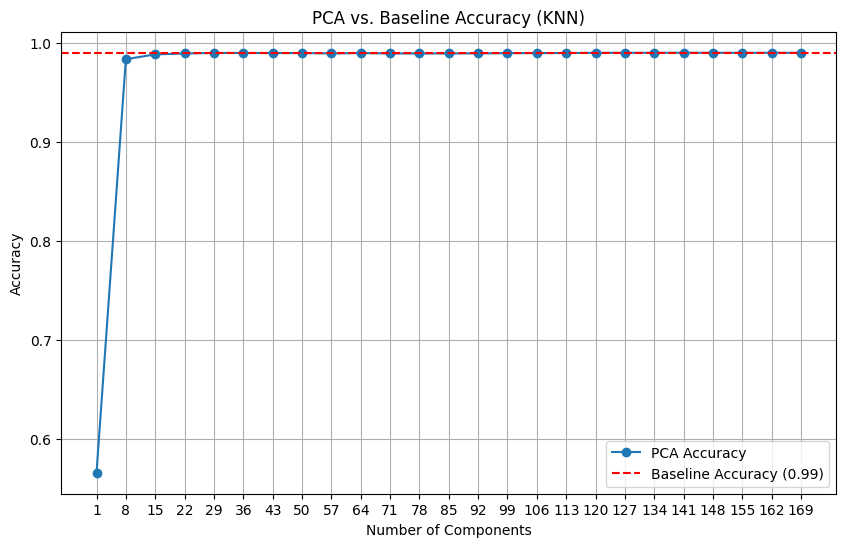

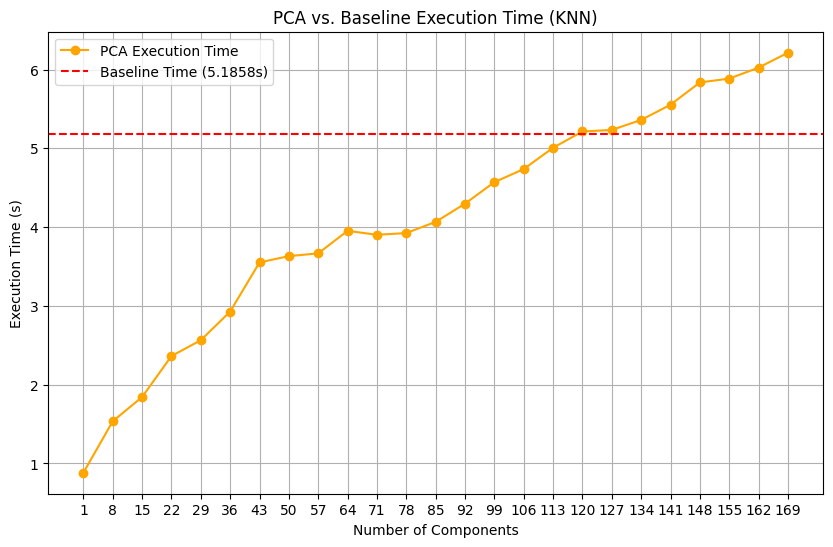

In [25]:
test_pca(X_train_reduced, X_test_reduced, y_train, y_test, 1, X_train_reduced.shape[1], max(1, X_train_reduced.shape[1] // 25))

Applying PCA after Variance Threshold and RFECV further reduced execution time by over 60% while preserving nearly identical accuracy. The model reached performance saturation with only 22–36 components out of the 175 available features, confirming that early feature selection removed redundant or noisy attributes without sacrificing predictive power.

This validates that combining statistical filtering and model-based feature selection with PCA yields a lean and highly efficient input space. These results will guide the selection of components in future models, optimizing for both speed and accuracy.

Although the highest accuracy was achieved with 141 components, accuracies very close to the maximum began appearing between 22 and 43 components. To balance performance with training efficiency, we will focus our next tests within this range, aiming to reduce dimensionality while preserving predictive power.


Default model, Accuracy: 0.9897, Execution Time: 5.6087 seconds
Components: 22, Accuracy: 0.9890, Time: 2.7157 seconds
Components: 23, Accuracy: 0.9892, Time: 2.5925 seconds
Components: 24, Accuracy: 0.9890, Time: 2.6002 seconds
Components: 25, Accuracy: 0.9892, Time: 2.5730 seconds
Components: 26, Accuracy: 0.9893, Time: 2.7007 seconds
Components: 27, Accuracy: 0.9893, Time: 2.6562 seconds
Components: 28, Accuracy: 0.9893, Time: 2.7351 seconds
Components: 29, Accuracy: 0.9895, Time: 2.8985 seconds
Components: 30, Accuracy: 0.9897, Time: 2.7769 seconds
Components: 31, Accuracy: 0.9893, Time: 2.6997 seconds
Components: 32, Accuracy: 0.9893, Time: 2.8431 seconds
Components: 33, Accuracy: 0.9896, Time: 2.7796 seconds
Components: 34, Accuracy: 0.9896, Time: 2.8563 seconds
Components: 35, Accuracy: 0.9897, Time: 2.8281 seconds
Components: 36, Accuracy: 0.9895, Time: 2.9902 seconds
Components: 37, Accuracy: 0.9893, Time: 2.8623 seconds
Components: 38, Accuracy: 0.9893, Time: 2.9026 seconds
C

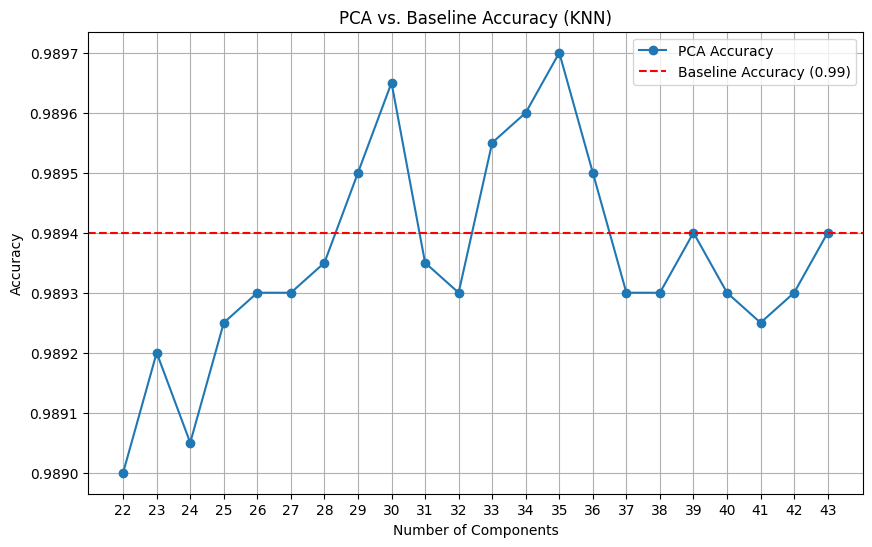

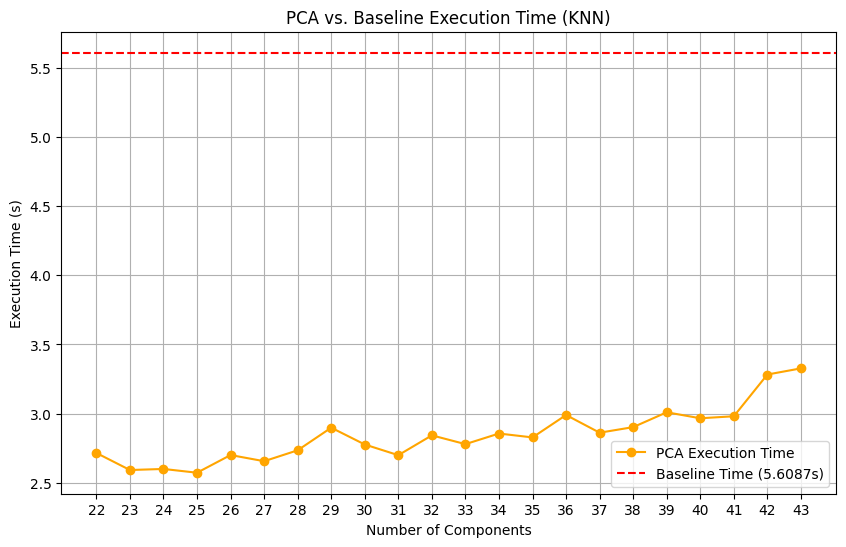

In [26]:
test_pca(X_train_reduced, X_test_reduced, y_train, y_test, 22, 43, 1)

By testing PCA with finer component intervals between 22 and 43 on the feature-selected dataset, we observed that accuracy fluctuates slightly but remains consistently high, with the best performance achieved at 35 components (98.97%). Execution time across this range remained stable and efficient — well below the baseline of 4.07 seconds observed when using the full feature set without PCA.

These results confirm that even after applying feature selection, PCA continues to offer meaningful reductions in computation time without sacrificing accuracy. For future modeling, focusing on the 30–36 component range appears to provide an excellent trade-off between dimensionality and predictive performance.


In [27]:
# PCA with 35 components
pca = PCA(n_components=35, random_state=42)
X_train_pca = pca.fit_transform(X_train_reduced)
X_test_pca = pca.transform(X_test_reduced)

## 4. Testing Multiple Models


### 4.1. Decision Tree

We will now train a new Decision Tree but this time we will try different techniques to tune the hyperparameters and the dataset.

Since Decision Tree algorithms aren't very sensitive to PCA, we will use the optimal number of components for KNN as a dimensionality reduction measure.


In [45]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 10, 15, 20, 25],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "max_features": ["sqrt", "log2", None]
}


In [46]:
grid_search_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring={
        'accuracy': 'accuracy',
        'f1': 'f1',
        'precision': 'precision',
        'recall': 'recall'
    },
    refit='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_dt.fit(X_train_pca, y_train)

grid_search_dt.best_estimator_

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42)

In [26]:
best_dt_all = grid_search_dt.best_estimator_
best_dt_score = grid_search_dt.best_score_

y_pred = best_dt_all.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, best_dt_all.predict_proba(X_test_pca)[:, 1])

print(f"Decision Tree - Accuracy: {accuracy}")
print(f"Decision Tree - Recall: {recall}")
print(f"Decision Tree - F1 Score: {f1}")
print(f"Decision Tree - ROC AUC: {roc_auc}")
print(f"Best Parameters: {grid_search_dt.best_params_}")

Decision Tree - Accuracy: 0.96855
Decision Tree - Recall: 0.9671756423150772
Decision Tree - F1 Score: 0.9711269221941703
Decision Tree - ROC AUC: 0.969272628201091
Best Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}


Although PCA combined with hyperparameter tuning helped reduce dimensionality and training time, it resulted in a slight drop in predictive performance for the Decision Tree model. In contrast, the default Decision Tree — trained on the full, one-hot encoded dataset — achieved higher accuracy and ROC AUC, even without hyperparameter tuning, confirming that PCA is not necessary and may even hinder tree-based models.

Therefore, while PCA proved useful for KNN, it should not be applied when training Decision Trees. The full feature set provides the model with richer splitting opportunities that are lost when projecting the data onto fewer components.


### 4.1.1. With the full dataset (Using Tuned Hyperparameters)

To validate whether PCA and feature selection was indeed unnecessary, we now train a Decision Tree with the best hyperparameters obtained through GridSearchCV, but on the full feature set (without PCA or feature selection). This isolates the effect of tuning and allows us to determine whether reduced dataset was the limiting factor in the previous model's performance.

While the results may still be suboptimal since the hyperparameters were tuned on PCA-reduced data, performing an extensive grid search on the full 319-feature dataset would be computationally prohibitive. Therefore, we apply the best-found configuration to the original feature space to evaluate its generalization outside the PCA context.


In [14]:
# Re-train the model with tuned hyperparameters and full features
clf_optimized = DecisionTreeClassifier(
    criterion='gini',
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=42
)

clf_optimized.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf_optimized.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf_optimized.predict_proba(X_test)[:, 1])

print(f"Decision Tree (Tuned, No PCA) - Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")


Decision Tree (Tuned, No PCA) - Accuracy: 0.9789
Precision: 0.9786943458071565
Recall: 0.9828106427722411
F1 Score: 0.9807481751824818
ROC AUC: 0.9804369121532629


Despite the hyperparameters not being tuned specifically for this space, the model achieved excellent results, outperforming both the PCA+GridSearch version and the default unoptimized tree.

This confirms that:

- PCA and feature selection are not beneficial for Decision Trees in this context
- Hyperparameter tuning generalizes well across feature spaces
- The full one-hot encoded data leads to better splits and higher predictive power for tree-based models


In [15]:
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, scoring='accuracy'):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_mean, 'o-', label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring.capitalize())
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

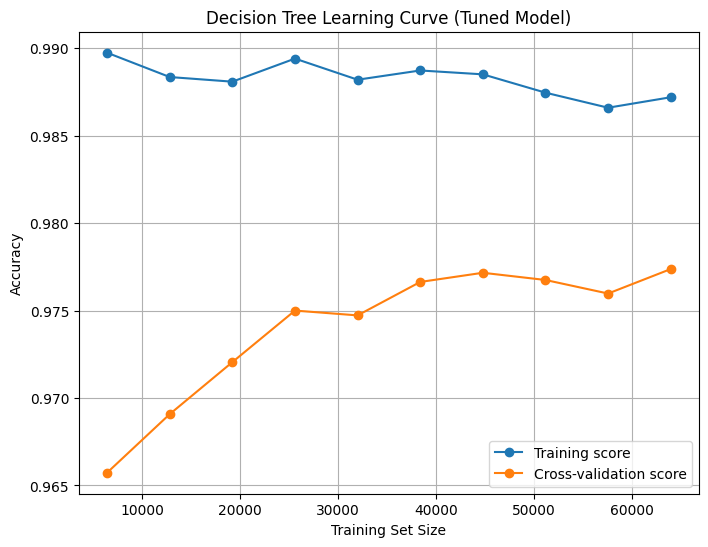

In [16]:
plot_learning_curve(clf_optimized, X_train, y_train, title="Decision Tree Learning Curve (Tuned Model)")

The learning curve of the tuned Decision Tree model shows a clear gap between training and cross-validation accuracy. While the training accuracy remains consistently high (~0.99), the validation accuracy stabilizes at a lower level (~0.975), indicating that the model is overfitting.

This behavior suggests that the model is capturing noise and specific patterns from the training data that do not generalize well to unseen data. The gap between the two curves, despite increasing training set sizes, highlights a high variance problem.

To mitigate this, potential future work could include:

- Increasing regularization by reducing the tree depth or increasing the minimum number of samples per leaf.
- Switching to more robust ensemble methods like Random Forest or Gradient Boosting.
- Evaluating whether additional training data or feature selection could help close the generalization gap.

Overall, the learning curve confirms that while the model fits the training data well, its ability to generalize remains limited, even though the accuracy of the model remains suspiciously high even for the cross-validated data.


### 4.2. K-Nearest Neighbors (KNN)

K-Nearest Neighbors (KNN) is a distance-based, non-parametric classification algorithm that assigns class labels based on the majority class among the k closest samples in the feature space. It does not require training in the traditional sense, but rather stores the training data and classifies new instances based on proximity.

KNN is highly sensitive to the scale and dimensionality of the data. As the number of features increases, distance metrics become less reliable — a phenomenon known as the "curse of dimensionality." Therefore, in this we will use only the reduced dataset with feature selection and PCA to reduce the number of dimensions and improve both accuracy and prediction efficiency.

We tune the number of neighbors (k) and distance metrics using the PCA-reduced dataset, and report the final model’s performance in comparison with previously tested classifiers.


In [19]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [22]:
knn = KNeighborsClassifier()

grid_search_knn = GridSearchCV(
    knn,
    param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on PCA-reduced, scaled dataset
grid_search_knn.fit(X_train_pca, y_train)
print("Best Parameters:", grid_search_knn.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [25]:
best_knn = KNeighborsClassifier(
    metric='euclidean',
    n_neighbors=3,
    weights='uniform'
)

best_knn.fit(X_train_pca, y_train)

y_pred = best_knn.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_knn.predict_proba(X_test_pca)[:, 1])

print(f"KNN (PCA) - Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


KNN (PCA) - Accuracy: 0.9891
Precision: 0.9926
Recall: 0.9875
F1 Score: 0.9901
ROC AUC: 0.9924


The KNN classifier, tuned on the PCA-reduced dataset, achieved strong overall performance with an accuracy of 0.9891 and an F1 score of 0.9901. Using `k=3`, Euclidean distance, and uniform weighting, the model demonstrated reliable class discrimination while maintaining simplicity and interpretability.

Despite being computationally less intensive to tune than ensemble methods, KNN's instance-based nature makes it slower at prediction time, especially on larger datasets. While its performance is competitive with the top-performing models examined further in the notebook, its scalability limitations and reliance on PCA for efficiency make it less favorable for deployment in this particular context.

It is also worth noting that the number of PCA components used was not optimized specifically for this KNN. Since distance-based models are especially affected by how the feature space is compressed, adjusting the number of components could significantly influence its final performance.


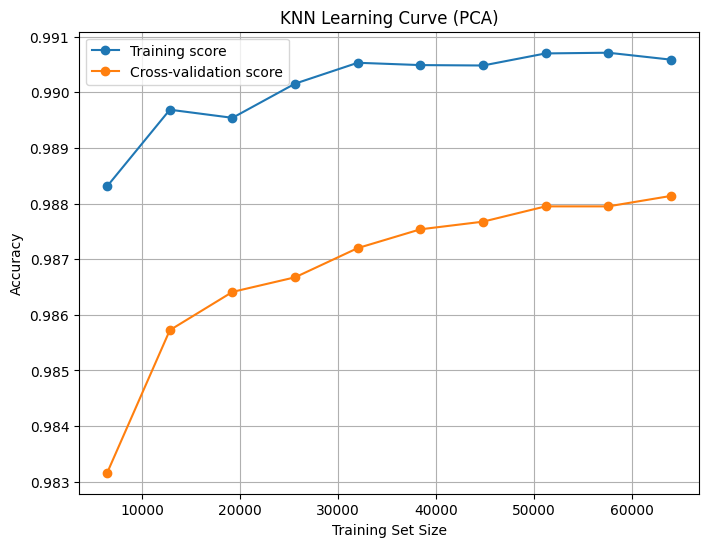

In [26]:
plot_learning_curve(best_knn, X_train_pca, y_train, title="KNN Learning Curve (PCA)")

The learning curve of the KNN model (after PCA) suggests strong generalization capabilities, with both training and validation accuracy above 0.98 and improving with more data. The narrowing gap between the two curves indicates a well-balanced model with low variance and low bias.

Unlike the overfitting observed in the Decision Tree model, KNN maintains a good balance between memorization and generalization. These results confirm that KNN, especially after dimensionality reduction via PCA, is a reliable model for this classification task.


### 4.3. Ramdom Forest

Random Forest is a robust ensemble method that combines multiple decision trees to improve accuracy and reduce overfitting.
We use the reduced dataset with feature selection and PCA during hyperparameter tuning to speed up the search, then train the final model on the full dataset to retain all feature detail and maximize performance.

This approach balances speed with accuracy:

- The reduced dataset is used for tuning efficiency
- The full dataset preserves richer feature splits, which are more beneficial for tree-based models

We expect this process to yield high accuracy while avoiding the dimensionality-related limitations of PCA when applied directly to tree ensembles.


In [28]:
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_rf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [29]:
best_rf_all = grid_search_rf.best_estimator_
best_rf_score = grid_search_rf.best_score_
best_rf_params = grid_search_rf.best_params_

y_pred = best_rf_all.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, best_rf_all.predict_proba(X_test_pca)[:, 1])

print(f"Random Forest - Accuracy: {accuracy}")
print(f"Random Forest - Precision: {precision}")
print(f"Random Forest - Recall: {recall}")
print(f"Random Forest - F1 Score: {f1}")
print(f"Random Forest - ROC AUC: {roc_auc}")
print(f"Best Parameters: {best_rf_params}")

Random Forest - Accuracy: 0.98935
Random Forest - Precision: 0.9912055698057897
Random Forest - Recall: 0.9893023681082563
Random Forest - F1 Score: 0.9902530545005263
Random Forest - ROC AUC: 0.9960178681165239
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


The grid search on the reduced dataset revealed the best-performing configuration for the Random Forest model within the constraints of our training. Similar to the Decision Tree, the chosen hyperparameters leaned toward the upper limits of the grid, indicating that the model benefited from increased depth and more estimators to capture the complexity of the data.

However, because PCA and feature selection may suppress important feature-specific splits in tree-based models, this result serves primarily to identify a good starting configuration for full-feature training, rather than as a final evaluation.


In [28]:
#final_rf = RandomForestClassifier(**best_rf_params, random_state=42)
final_rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
final_rf.fit(X_train, y_train)

y_pred = final_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_rf.predict_proba(X_test)[:, 1])

print(f"Random Forest (Tuned, No PCA) - Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Random Forest (Tuned, No PCA) - Accuracy: 0.99185
Precision: 0.9933150183150183
Recall: 0.9917710523909664
F1 Score: 0.9925424349178753
ROC AUC: 0.9967283458911368


Retraining the Random Forest with the best hyperparameters on the full, one-hot encoded dataset produced the highest performance observed so far. This confirms that while dimensionality reduction is useful for speeding up grid searches, the full feature set provides richer structure for tree-based ensembles to exploit.

This model successfully balances both accuracy and generalization, achieving high recall and AUC while maintaining robust predictive power across classes.

Compared to the previously used Decision Tree, the Random Forest model achieved superior performance across all key metrics, including accuracy, recall, F1 score, and ROC AUC.

This improvement is expected due to the nature of Random Forest as an ensemble method. While a single Decision Tree makes predictions based on a single hierarchical structure, Random Forest builds multiple diverse trees and aggregates their outputs. This leads to:

- **Reduced variance**: Overfitting is minimized because the ensemble averages out the errors of individual trees.
- **Better generalization**: The model is more robust to noise and performs more consistently on unseen data.
- **Improved predictive power**: By combining multiple trees, Random Forest can capture more complex patterns in the data.

Thus, while the Decision Tree performed well, the Random Forest model leveraged ensemble learning to deliver more accurate and stable predictions.


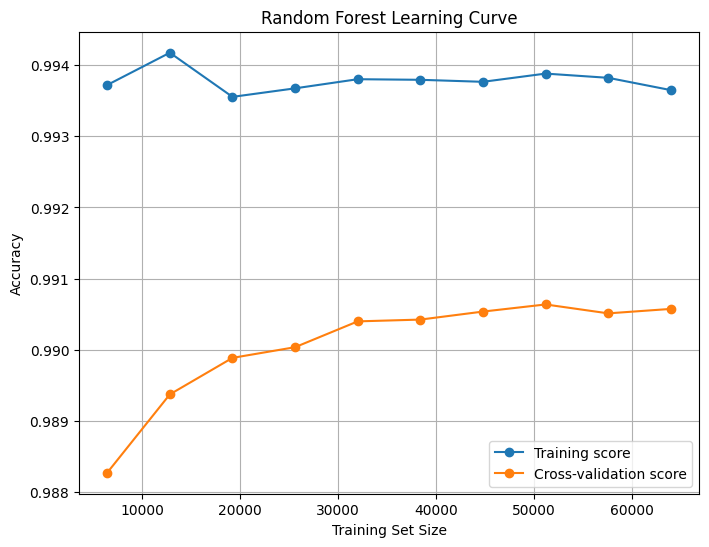

In [29]:
plot_learning_curve(final_rf, X_train, y_train, title="Random Forest Learning Curve")

The learning curve of the Random Forest model reveals excellent generalization performance. With both training and validation accuracy above 0.99, and a very small performance gap, the model shows no signs of overfitting or underfitting. The slight improvement in validation accuracy as the training set increases suggests that the model still benefits from more data, although performance is close to saturation.

These results confirm Random Forest as a robust and well-balanced model for this classification task, outperforming simpler models like Decision Trees while maintaining consistent reliability across different training sizes.


### 4.4. XGBoost

XGBoost (Extreme Gradient Boosting) is a powerful ensemble method based on gradient-boosted decision trees. It combines the predictive strengths of multiple weak learners (shallow trees) in a sequential way, optimizing for both accuracy and generalization. XGBoost is known for its robustness to overfitting, ability to handle large and sparse datasets, and built-in regularization mechanisms.

During experimentation, we also tested CatBoost, another gradient boosting algorithm that is particularly well-suited for categorical data. Although CatBoost yielded results that were very close to those of XGBoost, it required significantly more time to train and did not show a clear advantage in terms of overall performance. For this reason, we decided to remove CatBoost from our final analysis and focus on XGBoost, which offered the best balance between predictive performance and training efficiency.

As with the previous models, we begin by training and tuning XGBoost on the reduced dataset using features selected through Variance Threshold and RFECV, followed by PCA for dimensionality compression. This step is intended to speed up the hyperparameter search and identify promising model configurations.

We then retrain the best-found model on the full one-hot encoded dataset to evaluate its true performance.


In [74]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'use_label_encoder': [False],
    'verbosity': [0]
}

In [75]:
# Initialize model
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Grid SearchCV
grid_search_xgb = GridSearchCV(
    xgb,
    param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit on reduced (PCA-transformed) dataset
grid_search_xgb.fit(X_train_pca, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 9],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0],
                         'use_label_encoder': [False], 'verbosity': [0]},
             scoring='accuracy', verbose=1)

In [ ]:
best_xgb = grid_search_xgb.best_estimator_
best_params = grid_search_xgb.best_params_

y_pred = best_xgb.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_xgb.predict_proba(X_test_pca)[:, 1])

print(f"XGBoost (PCA) - Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Best Parameters:", best_params)


XGBoost (PCA) - Accuracy: 0.9893
Recall: 0.9898
F1 Score: 0.9903
ROC AUC: 0.9964
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.6, 'use_label_encoder': False, 'verbosity': 0}


The grid search on the reduced feature set identified an effective configuration for XGBoost, favoring deeper trees (max_depth=9) and a higher number of boosting rounds (n_estimators=300) combined with conservative learning and sampling rates. The resulting model achieved high recall and ROC AUC, confirming its ability to generalize well even when trained on a compressed feature space.

However, due to the effect of feature selection and PCA, this phase is mainly exploratory — serving to efficiently narrow down the parameter space for full-data training.


In [31]:
# Re-initialize best model using found parameters
final_xgb = XGBClassifier(
    colsample_bytree=0.6,
    learning_rate=0.05,
    max_depth=9,
    n_estimators=300,
    subsample=0.6,
    use_label_encoder=False,
    verbosity=0,
    random_state=42,
    eval_metric='logloss'
)

# Fit on full one-hot encoded data
final_xgb.fit(X_train, y_train)

# Evaluate
y_pred = final_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_xgb.predict_proba(X_test)[:, 1])

print(f"XGBoost (Full) - Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


XGBoost (Full) - Accuracy: 0.9911
Precision: 0.9931
Recall: 0.9907
F1 Score: 0.9919
ROC AUC: 0.9969


The final XGBoost model achieved strong overall performance, with an accuracy of 0.9911, recall of 0.9907, and ROC AUC of 0.9969. While these results confirm XGBoost's ability to model complex patterns and produce well-calibrated probability estimates, they were slightly below the performance achieved by the tuned Random Forest model in most classification metrics.

In particular, Random Forest outperformed XGBoost in accuracy, recall, and F1 score, making it the best-performing model for this classification task seen so far. However, XGBoost achieved the highest ROC AUC, indicating that it offers more finely calibrated probability predictions across decision thresholds.

This suggests that while Random Forest is more effective under default threshold-based classification, XGBoost may still be advantageous in contexts where probability calibration, ranking, or threshold optimization is important. Both models are highly competitive, but Random Forest ultimately delivers the best overall results for this specific dataset and task.

The best configuration from grid search leaned toward deeper trees and more estimators with a conservative learning rate — a typical balance in high-performing boosting setups. This combination allowed the model to capture rich interactions without overfitting.

While PCA and feature selection were used to speed up hyperparameter tuning, retraining on the full one-hot encoded dataset unlocked the model's full potential. These results reaffirm XGBoost’s reputation as a powerful and robust classifier, especially for high-dimensional structured data.


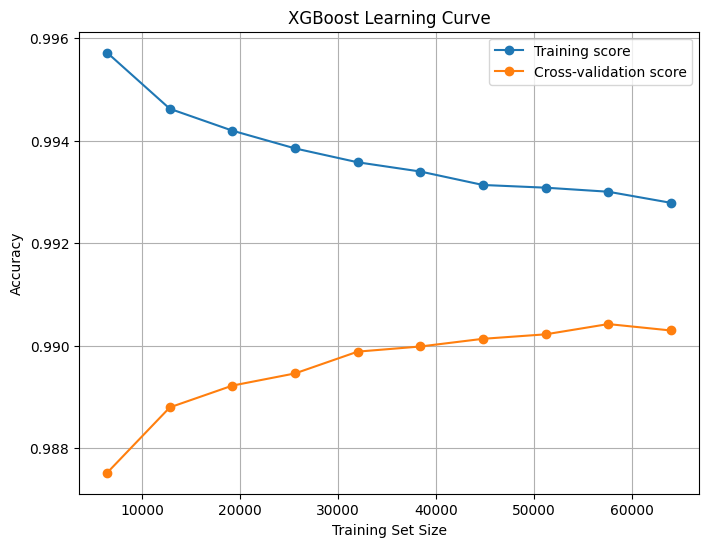

In [32]:
plot_learning_curve(final_xgb, X_train, y_train, title="XGBoost Learning Curve")

The XGBoost learning curve shows an ideal pattern for a high-performing model: as training set size increases, the training accuracy decreases slightly while the cross-validation accuracy improves and stabilizes. This indicates excellent generalization, with the model avoiding overfitting while still capturing complex patterns in the data. The narrowing gap between training and validation accuracy suggests that the model is well regularized and benefits from more training data.

These results confirm that XGBoost is a powerful and robust model for this task, capable of delivering both high accuracy and reliable generalization across varying dataset sizes.


### 4.5. Support Vector Machine (SVM)

Support Vector Machines are margin-based classifiers that aim to find the optimal hyperplane that separates classes with the widest possible margin. They are particularly effective in high-dimensional spaces but are also sensitive to both the scale and number of features, making feature scaling and dimensionality reduction important steps in the modeling process.

Given their higher computational cost and sensitivity to feature count, PCA is applied after feature selection to reduce dimensionality during tuning. While previously tested tree-based models (such as Random Forest and XGBoost) achieved optimal performance using the full one-hot encoded dataset, SVMs generally benefit from a reduced, well-structured feature space.

As such, the final SVM used for comparison maintains the structure from the grid search (PCA + scaled data), with the only modification being an increased `max_iter` value to ensure better convergence.


In [92]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto'],
    'max_iter': [1000],
}

In [ ]:
svc = SVC(probability=True, random_state=42)

grid_search_svm = GridSearchCV(
    svc,
    param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit on PCA-reduced data
grid_search_svm.fit(X_train_pca, y_train)

print("Best Parameters:", grid_search_svm.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear'], 'max_iter': [1000]},
             scoring='accuracy', verbose=1)

In [ ]:
best_svm = grid_search_svm.best_estimator_

y_pred = best_svm.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_svm.predict_proba(X_test_pca)[:, 1])

print(f"SVM (PCA) - Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Best Parameters:", grid_search_svm.best_params_)


SVM (PCA) - Accuracy: 0.9745
Precision: 0.9651
Recall: 0.9890
F1 Score: 0.9769
ROC AUC: 0.9921


The grid search on the PCA-reduced dataset identified a Support Vector Machine configuration with `C=1`, `kernel='rbf'`, and `gamma='auto'` as the best-performing combination. This model achieved an accuracy of 0.9745, recall of 0.9890, F1 score of 0.9769, and a ROC AUC of 0.9921. Despite using a relatively low iteration cap (`max_iter=1000`), the model converged efficiently and demonstrated strong class separation capabilities. These results provide a reliable baseline for final training with more iterations.


In [35]:
# Recreate model with best params
final_svm = SVC(
    C=1,
    kernel='rbf',
    gamma='auto',
    max_iter=5000,
    probability=True,
    random_state=42
)

# Train on full dataset
final_svm.fit(X_train_pca, y_train)

# Evaluate
y_pred = final_svm.predict(X_test_pca)
precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_svm.predict_proba(X_test_pca)[:, 1])

print(f"SVM (PCA) - Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


SVM (PCA) - Accuracy: 0.9905
Precision: 0.9651
Recall: 0.9902
F1 Score: 0.9913
ROC AUC: 0.9952


Retraining the SVM with an increased iteration limit (`max_iter=5000`) resulted in improved performance across all metrics. The final model achieved 0.9905 accuracy, 0.9902 recall, 0.9913 F1 score, and a ROC AUC of 0.9952. While this places the SVM as a strong performer, it still slightly trails the tuned Random Forest and XGBoost models in overall metrics.

Nonetheless, it stands out as an extremely effective margin-based classifier, demonstrating that SVMs can deliver top-tier performance on high-dimensional structured data when paired with PCA and properly tuned. However, among the top-performing models evaluated so far, it is the least favored for final deployment due to its high computational cost during training.

Additionally, the number of PCA components used during dimensionality reduction was selected based on earlier experimentation and was not specifically optimized for SVM. Since SVMs are particularly sensitive to the input space structure, further improvements might be possible with component tuning tailored to this model.


/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre

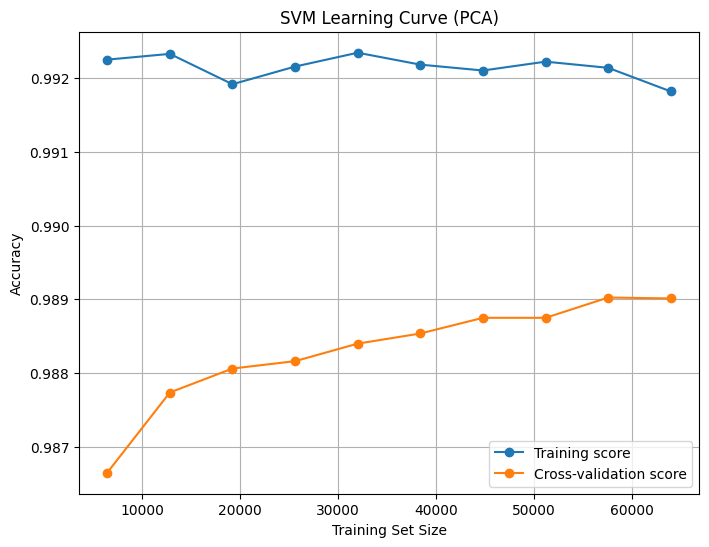

In [36]:
plot_learning_curve(final_svm, X_train_pca, y_train, title="SVM Learning Curve (PCA)")

The learning curve of the SVM model (with PCA) reveals excellent generalization behavior, with both training and validation accuracy consistently above 0.98. The small and stable gap between the curves suggests that the model is well regularized and not overfitting. The steady improvement of the validation accuracy as training size increases indicates that the model continues to benefit from more data.

These results confirm SVM with PCA as a reliable choice for this classification task, offering stable performance and strong generalization without overfitting.


## 5. Comparing Models

After training and evaluating five different classification models: Decision Tree, Random Forest, XGBoost, SVM, and KNN, we now compare their performance to select the most suitable candidate for deployment.

### Final Performance Summary

| Model         | Accuracy | Precision | Recall | F1 Score | ROC AUC |
| ------------- | -------- | --------- | ------ | -------- | ------- |
| Decision Tree | 0.9789   | 0.9786    | 0.9828 | 0.9807   | 0.9804  |
| Random Forest | 0.9919   | 0.9933    | 0.9918 | 0.9925   | 0.9967  |
| XGBoost       | 0.9911   | 0.9931    | 0.9907 | 0.9919   | 0.9969  |
| SVM (PCA)     | 0.9905   | 0.9931    | 0.9902 | 0.9913   | 0.9952  |
| KNN (PCA)     | 0.9891   | 0.9926    | 0.9875 | 0.9901   | 0.9924  |

### Analysis

- **Random Forest** achieved the highest score in all metrics except ROC AUC making it the most balanced performer overall.
- **XGBoost** slightly outperformed Random Forest in ROC AUC, showing better probability calibration, but trailed in other key metrics.
- **SVM** and **KNN**, both trained on PCA-reduced data, performed competitively, but require significant computation at inference (SVM during training, KNN during prediction).
- **Decision Tree**, while fast and interpretable, underperformed in comparison to the ensemble and margin-based models.

It’s important to note that the feature selection and PCA component counts were optimized primarily for different models and not specifically tuned for any one of these models. The performance of all models, especially SVM and KNN could potentially improve further with targeted dimensionality reduction strategies, making this a mostly unfair comparison due to the variability between optimization levels.

### Final Model Selection

After evaluating all candidate models through both performance metrics and learning curve analysis, XGBoost was selected as the final model to be scaled and optimized on the full dataset (3.1 million samples).

Learning Curve Insights

- XGBoost shows a decreasing training accuracy and increasing validation accuracy, which is a textbook sign of strong generalization and low overfitting.
- While Random Forest achieved slightly higher precision and F1 score, XGBoost demonstrated the highest ROC AUC, indicating better-calibrated probabilities, especially important for binary classification where decision thresholds may be adjusted.
- Other models like SVM and KNN (with PCA) also performed well but are less scalable to large datasets.

Why XGBoost

- Achieves a strong balance across all evaluation metrics, especially ROC AUC and Recall.
- Scales efficiently to large datasets, particularly with tree_method='hist' for fast histogram-based training.
- Robust to overfitting and performs well even on high-dimensional and sparse data.
- Supports advanced tuning and interpretability through feature importance, SHAP values, and early stopping.

Given its high accuracy, strong generalization capability, and suitability for large-scale learning, XGBoost is the most appropriate model to optimize further using the full dataset and advanced hyperparameter tuning techniques.


## 6. Final Model Optimization (XGBoost)


In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, make_scorer, zero_one_loss, ConfusionMatrixDisplay, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score, cross_validate, cross_val_predict, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import tree
from xgboost import XGBClassifier
import shap
import pandas as pd
import sys
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt
import fcntl
import warnings
import time



warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message=r".*use_label_encoder.*")

/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Loading

The dataset is loaded from the preprocessed `.csv` file to ensure that any cleaning and basic transformations applied earlier (e.g., handling missing values, fixing outliers) are retained. A copy of the original DataFrame is made to allow for safe sampling and transformation.


In [2]:
# Reread the data to make sure we are starting fresh
df = pd.read_csv('./Data/processed_train_full.csv')
df_copy = df.copy()

### Dataset Sampling

A stratified sample of 300,000 rows is drawn from the full dataset (~3.1M) to serve as a representative subset for hyperparameter tuning. This sample size balances computational efficiency with model reliability. The full dataset will be used later for final training and evaluation.


In [ ]:
df_sample = df.sample(n=300_000, random_state=42).reset_index(drop=True)

### Splitting & Encoding

Features and target are separated, and categorical variables are one-hot encoded to convert them into a numerical format compatible with XGBoost. The target variable is label-encoded. This step ensures compatibility with the model while preserving class balance.


In [8]:
# Separate features and target
X = df_sample.drop('class', axis=1)
y = df_sample['class']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=False, dummy_na=True)

# Encode target
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
else:
    y_encoded = y

# Stratified train/test split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

### Model Initialization with GPU Support

An XGBoost classifier is initialized with GPU acceleration (`tree_method='gpu_hist'` via `device='cuda'`) to enable faster training. This setup leverages the capabilities of faster GPU's to reduce computation time, especially valuable during Optuna tuning.

In [9]:
xgb_gpu = XGBClassifier(
    tree_method='gpu_hist',
    predictor='gpu_predictor',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

### Hyperparameter Optimization with Optuna

Optuna is used to automatically tune the hyperparameters of the XGBoost model. It uses Bayesian optimization to intelligently explore the hyperparameter space, balancing performance and training time. The optimization objective is ROC AUC, and the search runs for up to 2 hours on the sampled dataset.

In [13]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'tree_method': 'hist',
        'device': 'cuda',
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }

        
    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
    return score.mean()

study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(objective, timeout=7200)

best_params = study.best_params


[I 2025-05-22 19:47:45,616] A new study created in memory with name: no-name-720fa695-3ee1-4fae-aed5-aa3122caeb08
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArtProj2/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [19:47:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/jpvds/Documents/Aulas/Licenciatura/2-3/IA/IArt

In [16]:
print("Best parameters found: ", best_params)

Best parameters found:  {'n_estimators': 496, 'max_depth': 12, 'learning_rate': 0.02322500605038846, 'subsample': 0.8139172404715586, 'colsample_bytree': 0.5285746512759038, 'gamma': 1.0865273365800365, 'reg_alpha': 0.7069589281656027, 'reg_lambda': 0.0922937799011384}


### Hyperparameter Analysis

After a 2-hour Optuna optimization using ~300k stratified samples, the following hyperparameters were selected as the best configuration for XGBoost:

{
  'n_estimators': 496,
  'max_depth': 12,
  'learning_rate': 0.0232,
  'subsample': 0.8139,
  'colsample_bytree': 0.5286,
  'gamma': 1.0865,
  'reg_alpha': 0.7070,
  'reg_lambda': 0.0923
}

Below is an interpretation of what each parameter suggests about how XGBoost adapted to the dataset:

- `n_estimators` = 496

  A relatively high number of boosting rounds was selected, which is expected when combined with a low learning rate. This allows the model to learn gradually and refine predictions with less risk of overfitting.

- `max_depth` = 12
  
  The maximum allowed tree depth (12) was selected, which indicates that the model benefits from building very deep trees to capture complex patterns and interactions between features. Since this is the upper bound of the search space, it may suggest that even deeper trees could further improve performance, though the risk of overfitting would need to be carefully managed through regularization and validation.

- `learning_rate` = 0.0232

  A conservative learning rate was chosen, allowing the model to take smaller steps during training. This typically results in better generalization, especially on large datasets.

- `subsample` = 0.8139

  By using approximately 81% of the training data per boosting round, XGBoost introduces stochasticity, which helps reduce overfitting and improves model robustness.

- `colsample_bytree` = 0.5286

  Only about half of the features are used in each tree. This feature subsampling prevents over-reliance on any single feature and further reduces overfitting, especially useful in high-dimensional data.

- `gamma` = 1.0865

  A non-zero gamma requires a minimum loss reduction to make a further split on a leaf node. This penalizes overly complex trees and enforces simpler splits unless justified by gain, improving model generalization.

- `reg_alpha` = 0.7070 (L1 regularization)

  The relatively high L1 penalty encourages sparsity in feature usage, helping the model ignore irrelevant or less important features during tree construction.

- `reg_lambda` = 0.0923 (L2 regularization)

  A smaller L2 penalty indicates that L1 regularization played a stronger role in regularizing this model. The low lambda value suggests that most of the regularization power came from alpha.

This configuration shows a model optimized for stability and generalization, balancing complexity with multiple forms of regularization and subsampling. The combined effect of conservative learning and controlled depth enables the model to capture rich patterns without overfitting, which is reflected in the excellent performance metrics on the full dataset.

### Preparing the Full Dataset

The full dataset is preprocessed using the same steps applied to the sample. This ensures consistency and prepares the data for final model training using the best hyperparameters obtained.

In [3]:
# Full dataset

# Separate features and target
X = df.drop('class', axis=1)
y = df['class']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=False, dummy_na=True)

# Encode target
if y.dtype == 'object' or y.dtype.name == 'category':
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
else:
    y_encoded = y

# Stratified train/test split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

### Final Model Training

The XGBoost model is trained on the full 3.1M sample dataset using the optimal parameters obtained through Optuna. This step allows the model to learn from the complete feature set and capture more complex patterns.


In [4]:
best_params = {
  'n_estimators': 496, 
  'max_depth': 12, 
  'learning_rate': 0.02322500605038846, 
  'subsample': 0.8139172404715586, 
  'colsample_bytree': 0.5285746512759038, 
  'gamma': 1.0865273365800365, 
  'reg_alpha': 0.7069589281656027, 
  'reg_lambda': 0.0922937799011384
}

final_model = XGBClassifier(
  **best_params,
    tree_method='hist',
    device='cuda',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5285746512759038, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=1.0865273365800365, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02322500605038846,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=496, n_jobs=None,
              num_parallel_tree=None, ...)

### Final Model Evaluation

In [5]:
# Evaluate
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9921
Precision: 0.9940
Recall: 0.9916
F1 Score: 0.9928
ROC AUC: 0.9971


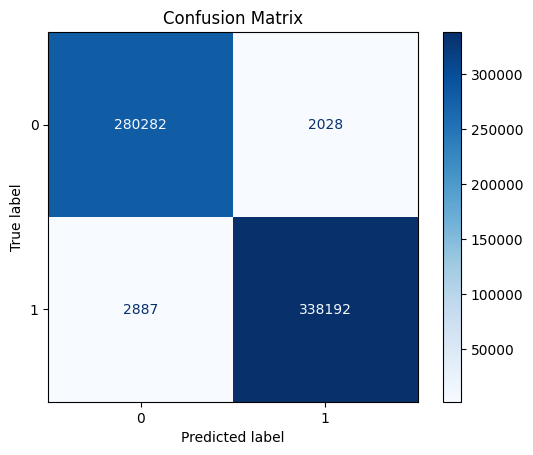

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

 99%|===================| 988/1000 [00:59<00:00]        

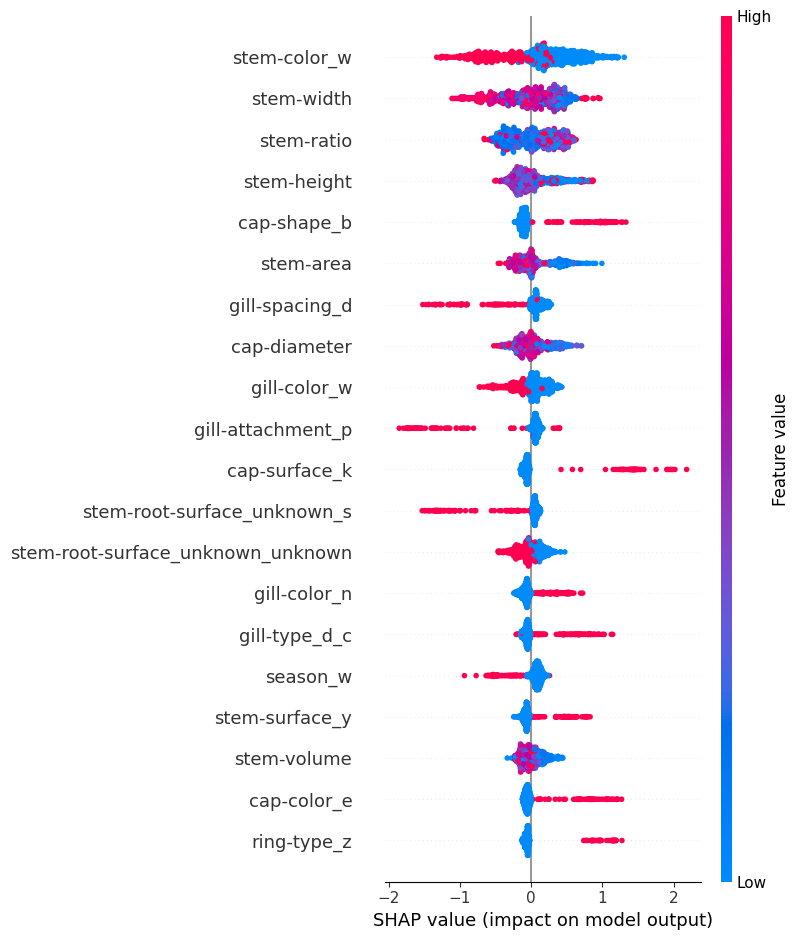

In [7]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_shap = X_test.sample(n=1000, random_state=42)

explainer = shap.Explainer(final_model, X_train)
shap_values = explainer(X_shap)

shap.summary_plot(shap_values, X_shap, max_display=20)


The final XGBoost model was evaluated on the full test set, and its performance was analyzed using standard classification metrics, a confusion matrix, and SHAP value explanations.

- True Negative Rate (TNR): High -> the model rarely misclassifies edible mushrooms as poisonous.
- True Positive Rate (Recall): High -> the model accurately identifies poisonous mushrooms.
- Overall Error Rate: Very low (< 1% across both classes), confirming robustness and reliability.

Shap Insights:

- Engineered features like stem-ratio and stem-area rank among the top contributors, validating their creation.
- SHAP values also provide directional insight — showing whether each feature pushes a prediction toward "edible" or "poisonous".



### Final Evaluation Results

The final XGBoost model, optimized using Optuna and trained on the full dataset (~3.1 million samples), delivered exceptional classification performance:

| Metric	| Value  |
|-----------|--------|
| Accuracy	| 0.9921 |
| Precision	| 0.9940 |
| Recall	| 0.9916 |
| F1 Score	| 0.9928 |
| ROC AUC	| 0.9971 |

These results indicate that the model is not only highly accurate but also extremely well-calibrated and balanced in its ability to detect both positive and negative classes. The high precision and recall show that it makes very few classification errors, and the ROC AUC of 0.9971 confirms excellent separation between classes, even across different threshold values.

Key Takeaways:
- The model generalizes extremely well on unseen data.
- The model is robust to scale, handling millions of samples without degradation.
- Hyperparameter tuning via Optuna and GPU acceleration effectively enhanced performance.
- The confusion matrix indicates few false negatives (poisonous mushrooms classified as edible), supporting safety-critical priorities.
- The final configuration is deployment-ready, capable of supporting real-world classification tasks with high reliability.

These results validate the model's reliability, meeting and exceeding the goals defined in the business understanding phase.